In [12]:
# Part 1: Initial Setup and Imports
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

# Set up NLTK data directory
import os
nltk_data_dir = os.path.expanduser('~/nltk_data')
if not os.path.exists(nltk_data_dir):
    os.makedirs(nltk_data_dir)

# Download NLTK data with SSL handling
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Download required NLTK packages
print("Downloading required NLTK data...")
for package in ['punkt', 'stopwords', 'wordnet', 'omw-1.4']:
    nltk.download(package, download_dir=nltk_data_dir)
print("NLTK data download completed!")

# Now import NLTK-specific modules
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

NLTK data download completed!


[nltk_data] Downloading package punkt to /Users/sahalrp/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sahalrp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sahalrp/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/sahalrp/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [13]:
# Part 2: Data Loading and Initial Examination
def load_and_examine_data():
    # Load datasets
    print("Loading datasets...")
    fake_df = pd.read_csv('../2_Data_Collection/data/Fake.csv')
    true_df = pd.read_csv('../2_Data_Collection/data/True.csv')
    
    # Display basic information
    print("\nFake News Dataset Info:")
    print(fake_df.info())
    print("\nTrue News Dataset Info:")
    print(true_df.info())
    
    # Display sample rows
    print("\nSample of Fake News:")
    print(fake_df[['title', 'text']].head(2))
    print("\nSample of True News:")
    print(true_df[['title', 'text']].head(2))
    
    return fake_df, true_df

# Load the data
fake_df, true_df = load_and_examine_data()

Loading datasets...

Fake News Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
None

True News Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB
None

Sample of Fake News:
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started R

In [14]:
# Part 3: Text Preprocessing Function
def preprocess_text(text):
    """
    Function to clean and preprocess text data
    """
    try:
        if not isinstance(text, str):
            return ''
            
        # Convert to lowercase
        text = text.lower()
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        
        # Remove email addresses
        text = re.sub(r'\S+@\S+', '', text)
        
        # Remove special characters and digits
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        
        # Tokenization
        tokens = text.split()
        
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]
        
        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        
        # Join tokens back into text
        return ' '.join(tokens)
    except Exception as e:
        print(f"Error in preprocessing: {e}")
        return text

# Test the preprocessing function
test_text = "This is a test sentence! With some numbers 123 and special characters @#$. http://example.com user@email.com"
print("Original:", test_text)
print("Preprocessed:", preprocess_text(test_text))

Original: This is a test sentence! With some numbers 123 and special characters @#$. http://example.com user@email.com
Preprocessed: test sentence number special character


In [21]:
# Part 4: Process and Combine Datasets with Filtering
def process_and_combine_datasets():
    """
    Load, process, combine, and filter the fake and true news datasets.
    """
    import os
    
    # Get the current working directory
    current_dir = os.getcwd()
    print(f"Current working directory: {current_dir}")
    
    # Construct absolute paths
    fake_path = os.path.join(current_dir, '..', '2_Data_Collection', 'data', 'Fake.csv')
    true_path = os.path.join(current_dir, '..', '2_Data_Collection', 'data', 'True.csv')
    
    # Check if files exist
    if not os.path.exists(fake_path):
        print(f"Error: Could not find fake news dataset at {fake_path}")
        return None
    if not os.path.exists(true_path):
        print(f"Error: Could not find true news dataset at {true_path}")
        return None
        
    print(f"Found datasets at:\n{fake_path}\n{true_path}")
    
    print("Loading datasets...")
    try:
        # Load datasets
        fake_df = pd.read_csv(fake_path)
        true_df = pd.read_csv(true_path)
        
        # Add labels (0 for fake, 1 for true)
        fake_df['label'] = 0
        true_df['label'] = 1
        
        print("Processing text data...")
        # Process text in both datasets
        fake_df['text'] = fake_df['text'].apply(preprocess_text)
        fake_df['title'] = fake_df['title'].apply(preprocess_text)
        true_df['text'] = true_df['text'].apply(preprocess_text)
        true_df['title'] = true_df['title'].apply(preprocess_text)
        
        # Combine datasets
        news_df = pd.concat([fake_df, true_df], axis=0, ignore_index=True)
        
        # Add text length features
        news_df['text_length'] = news_df['text'].apply(len)
        news_df['title_length'] = news_df['title'].apply(len)
        
        print("Filtering dataset...")
        # Filter out entries with empty text or titles
        news_df = news_df[news_df['text'].str.len() > 0]
        news_df = news_df[news_df['title'].str.len() > 0]
        
        # Filter out extremely short texts (less than 50 characters)
        news_df = news_df[news_df['text_length'] >= 50]
        
        # Filter out extremely long texts (above 99th percentile)
        text_length_threshold = news_df['text_length'].quantile(0.99)
        news_df = news_df[news_df['text_length'] <= text_length_threshold]
        
        # Remove duplicates
        news_df = news_df.drop_duplicates(subset=['text', 'title'], keep='first')
        
        # Reset index after filtering
        news_df = news_df.reset_index(drop=True)
        
        print(f"Final dataset shape after filtering: {news_df.shape}")
        print("\nClass distribution after filtering:")
        print(news_df['label'].value_counts(normalize=True))
        
        return news_df
        
    except Exception as e:
        print(f"Error processing datasets: {str(e)}")
        return None

# Process and combine the datasets
news_df = process_and_combine_datasets()

# Check if processing was successful
if news_df is not None:
    print("Dataset processing completed successfully!")
else:
    print("Dataset processing failed. Please check the error messages above.")

Current working directory: /Users/sahalrp/Documents/FakeNewsDetection_Development/3_Data_Analysis
Found datasets at:
/Users/sahalrp/Documents/FakeNewsDetection_Development/3_Data_Analysis/../2_Data_Collection/data/Fake.csv
/Users/sahalrp/Documents/FakeNewsDetection_Development/3_Data_Analysis/../2_Data_Collection/data/True.csv
Loading datasets...
Processing text data...
Filtering dataset...
Final dataset shape after filtering: (38043, 7)

Class distribution after filtering:
label
1    0.552717
0    0.447283
Name: proportion, dtype: float64
Dataset processing completed successfully!


/var/folders/h5/xk9dvpn919jbdbwpxy8pyln40000gn/T/ipykernel_24715/2092519863.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=news_df, x='label', palette=['red', 'green'])
/var/folders/h5/xk9dvpn919jbdbwpxy8pyln40000gn/T/ipykernel_24715/2092519863.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=news_df, x='label', y='text_length', palette=['red', 'green'])
/var/folders/h5/xk9dvpn919jbdbwpxy8pyln40000gn/T/ipykernel_24715/2092519863.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=news_df, x='label', y='title_lengt

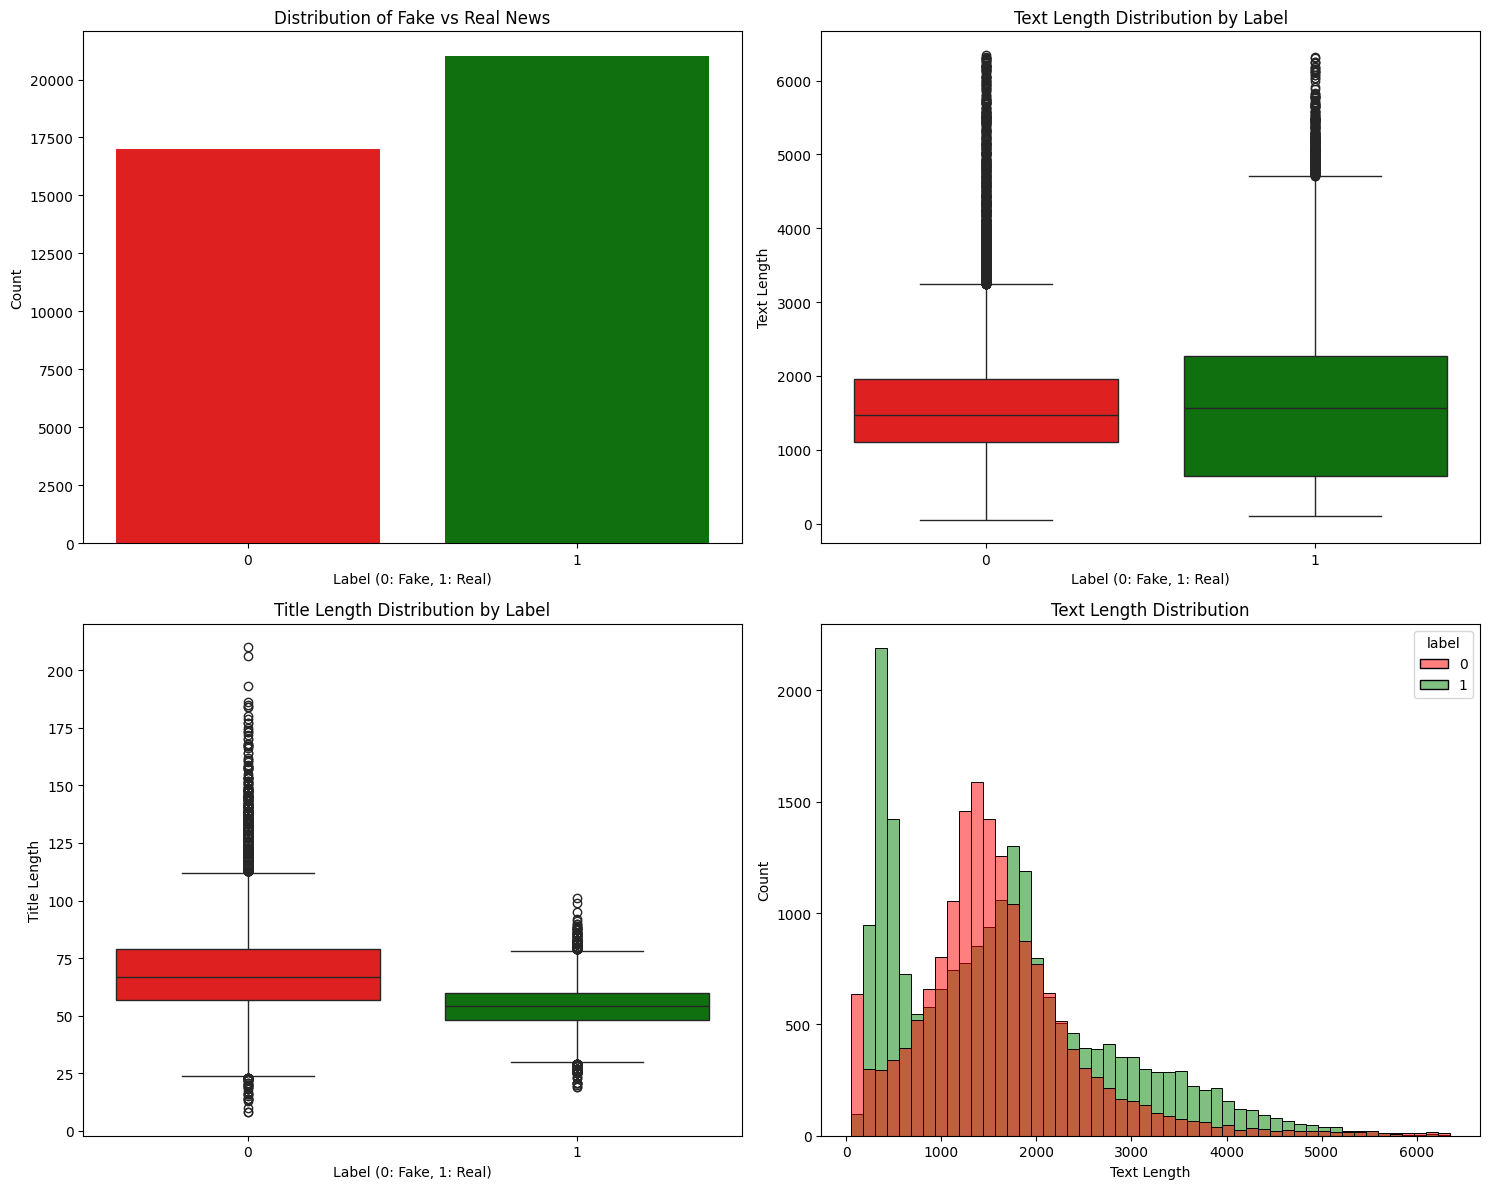


Dataset Statistics:
Total number of articles: 38043
Number of fake articles: 17016
Number of real articles: 21027

Text Length Statistics by Label:

Fake News (Label 0):
        text_length  title_length
count  17016.000000  17016.000000
mean    1592.041490     70.152562
std      886.870015     20.138728
min       50.000000      8.000000
25%     1102.000000     57.000000
50%     1473.000000     67.000000
75%     1959.000000     79.000000
max     6353.000000    210.000000

Real News (Label 1):
        text_length  title_length
count  21027.000000  21027.000000
mean    1674.297142     54.090503
std     1136.381252      8.832382
min      102.000000     19.000000
25%      652.000000     48.000000
50%     1568.000000     54.000000
75%     2275.000000     60.000000
max     6322.000000    101.000000


In [22]:
# Part 5: Analysis and Visualization
def analyze_and_visualize(news_df):
    """
    Create visualizations and statistical analysis of the dataset.
    
    Parameters:
    -----------
    news_df : pandas.DataFrame
        The preprocessed and filtered news DataFrame
    """
    # Set style for better visualizations
    plt.style.use('default')
    
    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(15, 12))
    
    # Plot 1: Distribution of labels (Fake vs Real)
    plt.subplot(2, 2, 1)
    sns.countplot(data=news_df, x='label', palette=['red', 'green'])
    plt.title('Distribution of Fake vs Real News')
    plt.xlabel('Label (0: Fake, 1: Real)')
    plt.ylabel('Count')
    
    # Plot 2: Box plot of text lengths by label
    plt.subplot(2, 2, 2)
    sns.boxplot(data=news_df, x='label', y='text_length', palette=['red', 'green'])
    plt.title('Text Length Distribution by Label')
    plt.xlabel('Label (0: Fake, 1: Real)')
    plt.ylabel('Text Length')
    
    # Plot 3: Box plot of title lengths by label
    plt.subplot(2, 2, 3)
    sns.boxplot(data=news_df, x='label', y='title_length', palette=['red', 'green'])
    plt.title('Title Length Distribution by Label')
    plt.xlabel('Label (0: Fake, 1: Real)')
    plt.ylabel('Title Length')
    
    # Plot 4: Histogram of text lengths by label
    plt.subplot(2, 2, 4)
    sns.histplot(data=news_df, x='text_length', hue='label', bins=50, 
                alpha=0.5, palette=['red', 'green'])
    plt.title('Text Length Distribution')
    plt.xlabel('Text Length')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistical summaries
    print("\nDataset Statistics:")
    print(f"Total number of articles: {len(news_df)}")
    print(f"Number of fake articles: {len(news_df[news_df['label'] == 0])}")
    print(f"Number of real articles: {len(news_df[news_df['label'] == 1])}")
    
    print("\nText Length Statistics by Label:")
    print("\nFake News (Label 0):")
    print(news_df[news_df['label'] == 0][['text_length', 'title_length']].describe())
    print("\nReal News (Label 1):")
    print(news_df[news_df['label'] == 1][['text_length', 'title_length']].describe())

# Generate visualizations and statistics
analyze_and_visualize(news_df)

In [23]:
# Part 6: Save the Filtered Dataset
def save_filtered_dataset(news_df):
    """
    Save the filtered dataset to both the analysis folder and current directory.
    
    Parameters:
    -----------
    news_df : pandas.DataFrame
        The preprocessed and filtered news DataFrame
    """
    try:
        # Save in 3_Data_Analysis folder
        analysis_path = '../3_Data_Analysis/news.csv'
        os.makedirs(os.path.dirname(analysis_path), exist_ok=True)
        news_df.to_csv(analysis_path, index=False)
        print(f"Successfully saved filtered dataset to {analysis_path}")
        
        # Save in current directory
        current_path = 'news.csv'
        news_df.to_csv(current_path, index=False)
        print(f"Successfully saved filtered dataset to {current_path}")
        
        # Print dataset information
        print("\nFiltered Dataset Information:")
        print(f"Total number of articles: {len(news_df)}")
        print(f"Number of features: {len(news_df.columns)}")
        print("\nFeatures in the dataset:")
        for col in news_df.columns:
            print(f"- {col}")
        
        print("\nClass distribution in the filtered dataset:")
        class_dist = news_df['label'].value_counts(normalize=True)
        print(f"Fake news (0): {class_dist[0]:.2%}")
        print(f"Real news (1): {class_dist[1]:.2%}")
        
        print("\nSample of the filtered dataset:")
        print(news_df.head())
        
    except Exception as e:
        print(f"Error saving the dataset: {str(e)}")

# Save the filtered dataset
save_filtered_dataset(news_df)

Successfully saved filtered dataset to ../3_Data_Analysis/news.csv
Successfully saved filtered dataset to news.csv

Filtered Dataset Information:
Total number of articles: 38043
Number of features: 7

Features in the dataset:
- title
- text
- subject
- date
- label
- text_length
- title_length

Class distribution in the filtered dataset:
Fake news (0): 44.73%
Real news (1): 55.27%

Sample of the filtered dataset:
                                               title  \
0  donald trump sends embarrassing new year eve m...   
1  drunk bragging trump staffer started russian c...   
2  sheriff david clarke becomes internet joke thr...   
3  trump obsessed even obamas name coded website ...   
4  pope francis called donald trump christmas speech   

                                                text subject  \
0  donald trump wish american happy new year leav...    News   
1  house intelligence committee chairman devin nu...    News   
2  friday revealed former milwaukee sheriff david...  

In [25]:
def create_requirements():
    """
    Create a requirements.txt file with necessary packages for the project.
    """
    requirements = """
pandas>=1.5.0
numpy>=1.21.0
nltk>=3.6.0
scikit-learn>=1.0.0
textblob>=0.15.3
matplotlib>=3.4.0
seaborn>=0.11.0
jupyter>=1.0.0
"""
    
    try:
        with open('requirements.txt', 'w') as f:
            f.write(requirements.strip())
        print("Successfully created requirements.txt")
        
    except Exception as e:
        print(f"Error creating requirements.txt: {str(e)}")

# Create the requirements file
create_requirements()

Successfully created requirements.txt


In [26]:
# Part 7: Text Complexity Analysis
def analyze_text_complexity(text, title):
    """
    Analyze text complexity using basic metrics.
    
    Parameters:
    -----------
    text : str
        The main text content
    title : str
        The title of the text
        
    Returns:
    --------
    dict
        Dictionary containing complexity metrics
    """
    # 1. Average word length
    words = text.split()
    avg_word_length = sum(len(word) for word in words) / len(words) if words else 0
    
    # 2. Sentence count (splitting by ., !, ?)
    sentences = [s.strip() for s in text.replace('!', '.').replace('?', '.').split('.') if s.strip()]
    sentence_count = len(sentences)
    
    # 3. Average sentence length
    avg_sentence_length = len(words) / sentence_count if sentence_count > 0 else 0
    
    return {
        'avg_word_length': round(avg_word_length, 2),
        'sentence_count': sentence_count,
        'avg_sentence_length': round(avg_sentence_length, 2)
    }

# Example usage:
# Let's analyze one article first
sample_text = news_df.iloc[0]['text']
sample_title = news_df.iloc[0]['title']
complexity_metrics = analyze_text_complexity(sample_text, sample_title)
print("\nText Complexity Analysis for first article:")
for metric, value in complexity_metrics.items():
    print(f"{metric}: {value}")


Text Complexity Analysis for first article:
avg_word_length: 5.69
sentence_count: 1
avg_sentence_length: 245.0


In [27]:
# Part 8: Stylometric Feature Analysis
def analyze_stylometric_features(text):
    """
    Extract stylometric features from text.
    
    Parameters:
    -----------
    text : str
        The text to analyze
        
    Returns:
    --------
    dict
        Dictionary containing stylometric features
    """
    # 1. Punctuation patterns
    exclamation_count = text.count('!')
    question_count = text.count('?')
    quotes_count = text.count('"') + text.count("'")
    
    # 2. Capitalization patterns
    words = text.split()
    capitalized_words = sum(1 for word in words if word and word[0].isupper())
    all_caps_words = sum(1 for word in words if word.isupper() and len(word) > 1)
    
    # 3. Special character patterns
    special_chars = sum(1 for char in text if not char.isalnum() and not char.isspace())
    
    return {
        'exclamation_density': exclamation_count / len(words) if words else 0,
        'question_density': question_count / len(words) if words else 0,
        'quotes_density': quotes_count / len(words) if words else 0,
        'capitalized_ratio': capitalized_words / len(words) if words else 0,
        'all_caps_ratio': all_caps_words / len(words) if words else 0,
        'special_chars_density': special_chars / len(words) if words else 0
    }

In [28]:
# Test the stylometric analysis
# First, let's make sure we have our dataset loaded
try:
    # Check if news_df exists and has content
    print("Dataset shape:", news_df.shape)
    
    # Test with a single article first
    print("\nTesting with first article:")
    sample_text = news_df.iloc[0]['text']
    sample_features = analyze_stylometric_features(sample_text)
    print("\nStylometric features for first article:")
    for feature, value in sample_features.items():
        print(f"{feature}: {value}")
    
    # Now apply to full dataset
    print("\nApplying to full dataset...")
    news_df = add_stylometric_features(news_df)
    
    # Show summary of new features
    print("\nSummary statistics of new features:")
    print(news_df[['exclamation_density', 'question_density', 'quotes_density', 
                   'capitalized_ratio', 'all_caps_ratio', 'special_chars_density']].describe())
    
    # Save the updated dataset
    news_df.to_csv('news_with_stylometric.csv', index=False)
    print("\nUpdated dataset saved as 'news_with_stylometric.csv'")
    
except NameError:
    print("Error: Please make sure the dataset (news_df) is loaded first!")
    print("You need to run the previous data loading and preprocessing steps before this analysis.")
except Exception as e:
    print(f"An error occurred: {str(e)}")

Dataset shape: (38043, 7)

Testing with first article:

Stylometric features for first article:
exclamation_density: 0.0
question_density: 0.0
quotes_density: 0.0
capitalized_ratio: 0.0
all_caps_ratio: 0.0
special_chars_density: 0.0

Applying to full dataset...
Error: Please make sure the dataset (news_df) is loaded first!
You need to run the previous data loading and preprocessing steps before this analysis.


In [29]:
# Load and verify the dataset
import pandas as pd

# Load the dataset from your previous saved file
news_df = pd.read_csv('news.csv')
print("Initial dataset shape:", news_df.shape)
print("\nColumns in dataset:", news_df.columns.tolist())
print("\nFirst few rows:")
print(news_df.head(2))

Initial dataset shape: (38043, 7)

Columns in dataset: ['title', 'text', 'subject', 'date', 'label', 'text_length', 'title_length']

First few rows:
                                               title  \
0  donald trump sends embarrassing new year eve m...   
1  drunk bragging trump staffer started russian c...   

                                                text subject  \
0  donald trump wish american happy new year leav...    News   
1  house intelligence committee chairman devin nu...    News   

                date  label  text_length  title_length  
0  December 31, 2017      0         1638            63  
1  December 31, 2017      0         1367            68  


In [30]:
def analyze_stylometric_features(text):
    # ... (your existing function code)
    pass

def add_stylometric_features(df):
    # ... (your existing function code)
    pass

In [31]:
# Apply stylometric analysis
print("Starting stylometric analysis...")

# Test with first article
sample_text = news_df.iloc[0]['text']
sample_features = analyze_stylometric_features(sample_text)
print("\nStylometric features for first article:")
for feature, value in sample_features.items():
    print(f"{feature}: {value}")

# Apply to full dataset
print("\nApplying to full dataset...")
news_df = add_stylometric_features(news_df)

# Save the updated dataset
news_df.to_csv('news_with_stylometric.csv', index=False)
print("\nUpdated dataset saved as 'news_with_stylometric.csv'")

# Show the new columns
print("\nNew columns added:", 
      [col for col in news_df.columns if col not in ['text', 'title', 'label']])

Starting stylometric analysis...

Stylometric features for first article:


AttributeError: 'NoneType' object has no attribute 'items'

In [32]:
def analyze_stylometric_features(text):
    """
    Extract stylometric features from text.
    
    Parameters:
    -----------
    text : str
        The text to analyze
        
    Returns:
    --------
    dict
        Dictionary containing stylometric features
    """
    # Ensure text is a string
    text = str(text)
    
    # 1. Punctuation patterns
    exclamation_count = text.count('!')
    question_count = text.count('?')
    quotes_count = text.count('"') + text.count("'")
    
    # 2. Capitalization patterns
    words = text.split()
    total_words = len(words) if words else 1  # Avoid division by zero
    capitalized_words = sum(1 for word in words if word and word[0].isupper())
    all_caps_words = sum(1 for word in words if word.isupper() and len(word) > 1)
    
    # 3. Special character patterns
    special_chars = sum(1 for char in text if not char.isalnum() and not char.isspace())
    
    return {
        'exclamation_density': round(exclamation_count / total_words, 4),
        'question_density': round(question_count / total_words, 4),
        'quotes_density': round(quotes_count / total_words, 4),
        'capitalized_ratio': round(capitalized_words / total_words, 4),
        'all_caps_ratio': round(all_caps_words / total_words, 4),
        'special_chars_density': round(special_chars / total_words, 4)
    }

def add_stylometric_features(df):
    """
    Add stylometric features to the dataframe
    """
    print("Adding stylometric features...")
    
    # Apply stylometric analysis to each text
    features = df['text'].apply(analyze_stylometric_features)
    
    # Convert the dictionary of features into separate columns
    for feature in ['exclamation_density', 'question_density', 'quotes_density', 
                   'capitalized_ratio', 'all_caps_ratio', 'special_chars_density']:
        df[feature] = features.apply(lambda x: x[feature])
    
    print("\nStylometric features added successfully!")
    print("\nFeature statistics:")
    print(df[['exclamation_density', 'question_density', 'quotes_density', 
              'capitalized_ratio', 'all_caps_ratio', 'special_chars_density']].describe())
    return df

# Now test the implementation
print("Starting stylometric analysis...")

# Test with first article
sample_text = news_df.iloc[0]['text']
sample_features = analyze_stylometric_features(sample_text)
print("\nStylometric features for first article:")
for feature, value in sample_features.items():
    print(f"{feature}: {value}")

# Apply to full dataset
print("\nApplying to full dataset...")
news_df = add_stylometric_features(news_df)

# Save the updated dataset
news_df.to_csv('news_with_stylometric.csv', index=False)
print("\nUpdated dataset saved as 'news_with_stylometric.csv'")

Starting stylometric analysis...

Stylometric features for first article:
exclamation_density: 0.0
question_density: 0.0
quotes_density: 0.0
capitalized_ratio: 0.0
all_caps_ratio: 0.0
special_chars_density: 0.0

Applying to full dataset...
Adding stylometric features...

Stylometric features added successfully!

Feature statistics:
       exclamation_density  question_density  quotes_density  \
count              38043.0           38043.0         38043.0   
mean                   0.0               0.0             0.0   
std                    0.0               0.0             0.0   
min                    0.0               0.0             0.0   
25%                    0.0               0.0             0.0   
50%                    0.0               0.0             0.0   
75%                    0.0               0.0             0.0   
max                    0.0               0.0             0.0   

       capitalized_ratio  all_caps_ratio  special_chars_density  
count            38043.

In [33]:
def enhance_stylometric_features(df):
    """
    Add additional stylometric features focusing on sentence structure
    """
    print("Adding enhanced stylometric features...")
    
    def analyze_sentence_structure(text):
        sentences = text.split('.')
        # Remove empty strings from sentence splitting
        sentences = [s.strip() for s in sentences if s.strip()]
        
        # Average sentence length (in words)
        sentence_lengths = [len(s.split()) for s in sentences]
        avg_sentence_length = sum(sentence_lengths) / len(sentences) if sentences else 0
        
        # Sentence length variation
        sentence_length_std = np.std(sentence_lengths) if len(sentences) > 1 else 0
        
        return {
            'avg_sentence_length': round(avg_sentence_length, 2),
            'sentence_length_std': round(sentence_length_std, 2),
            'num_sentences': len(sentences)
        }
    
    # Apply sentence structure analysis
    print("Analyzing sentence structure...")
    sentence_features = df['text'].apply(analyze_sentence_structure)
    
    # Add new features to dataframe
    for feature in ['avg_sentence_length', 'sentence_length_std', 'num_sentences']:
        df[feature] = sentence_features.apply(lambda x: x[feature])
    
    print("\nEnhanced features added successfully!")
    print("\nNew feature statistics:")
    print(df[['avg_sentence_length', 'sentence_length_std', 'num_sentences']].describe())
    return df

# Add the enhanced features
news_df = enhance_stylometric_features(news_df)

# Save the updated dataset
news_df.to_csv('news_with_enhanced_stylometric.csv', index=False)
print("\nUpdated dataset saved as 'news_with_enhanced_stylometric.csv'")

Adding enhanced stylometric features...
Analyzing sentence structure...

Enhanced features added successfully!

New feature statistics:
       avg_sentence_length  sentence_length_std  num_sentences
count         38043.000000              38043.0        38043.0
mean            221.314670                  0.0            1.0
std             138.886993                  0.0            0.0
min               5.000000                  0.0            1.0
25%             125.000000                  0.0            1.0
50%             205.000000                  0.0            1.0
75%             283.000000                  0.0            1.0
max             895.000000                  0.0            1.0

Updated dataset saved as 'news_with_enhanced_stylometric.csv'


In [34]:
from textblob import TextBlob
import numpy as np

def analyze_sentiment(df):
    """
    Add sentiment analysis features to the dataset
    """
    print("Adding sentiment analysis features...")
    
    def get_sentiment_features(text):
        # Create TextBlob object
        blob = TextBlob(str(text))
        
        # Get the sentiment polarity (-1 to 1, negative to positive)
        polarity = blob.sentiment.polarity
        
        # Get the subjectivity (0 to 1, objective to subjective)
        subjectivity = blob.sentiment.subjectivity
        
        # Get sentence-level sentiment stats
        sentence_polarities = [sentence.sentiment.polarity for sentence in blob.sentences]
        
        return {
            'polarity': round(polarity, 3),
            'subjectivity': round(subjectivity, 3),
            'sentiment_std': round(np.std(sentence_polarities) if sentence_polarities else 0, 3),
            'max_polarity': round(max(sentence_polarities) if sentence_polarities else 0, 3),
            'min_polarity': round(min(sentence_polarities) if sentence_polarities else 0, 3)
        }
    
    # Apply sentiment analysis
    print("Analyzing sentiment for all articles...")
    sentiment_features = df['text'].apply(get_sentiment_features)
    
    # Add features to dataframe
    for feature in ['polarity', 'subjectivity', 'sentiment_std', 'max_polarity', 'min_polarity']:
        df[feature] = sentiment_features.apply(lambda x: x[feature])
    
    # Add sentiment category for easier visualization in Streamlit
    df['sentiment_category'] = df['polarity'].apply(lambda x: 
        'Positive' if x > 0.1 else ('Negative' if x < -0.1 else 'Neutral'))
    
    print("\nSentiment features added successfully!")
    print("\nFeature statistics:")
    print(df[['polarity', 'subjectivity', 'sentiment_std', 'max_polarity', 'min_polarity']].describe())
    
    # Display sentiment distribution (useful for Streamlit visualization later)
    sentiment_dist = df['sentiment_category'].value_counts()
    print("\nSentiment Distribution:")
    print(sentiment_dist)
    
    return df

# Add sentiment features
news_df = analyze_sentiment(news_df)

# Save the updated dataset
news_df.to_csv('news_with_sentiment.csv', index=False)
print("\nUpdated dataset saved as 'news_with_sentiment.csv'")

Adding sentiment analysis features...
Analyzing sentiment for all articles...


MissingCorpusError: 
Looks like you are missing some required data for this feature.

To download the necessary data, simply run

    python -m textblob.download_corpora

or use the NLTK downloader to download the missing data: http://nltk.org/data.html
If this doesn't fix the problem, file an issue at https://github.com/sloria/TextBlob/issues.


In [35]:
import nltk

# Download required NLTK data
print("Downloading required NLTK data...")
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')
nltk.download('wordnet')

# Download TextBlob corpora
import subprocess
print("\nDownloading TextBlob corpora...")
subprocess.run(['python', '-m', 'textblob.download_corpora'])

print("\nAll required data downloaded successfully!")

[nltk_data] Downloading package punkt to /Users/sahalrp/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sahalrp/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to /Users/sahalrp/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package wordnet to /Users/sahalrp/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[nltk_data] Downloading package brown to /Users/sahalrp/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/sahalrp/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /Users/sahalrp/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/sahalrp/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/sahalrp/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/sahalrp/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


Finished.

All required data downloaded successfully!


In [36]:
from textblob import TextBlob
import numpy as np

def analyze_sentiment(df):
    """
    Add sentiment analysis features to the dataset
    """
    print("Adding sentiment analysis features...")
    
    def get_sentiment_features(text):
        try:
            # Create TextBlob object
            blob = TextBlob(str(text))
            
            # Get the sentiment polarity (-1 to 1, negative to positive)
            polarity = blob.sentiment.polarity
            
            # Get the subjectivity (0 to 1, objective to subjective)
            subjectivity = blob.sentiment.subjectivity
            
            # Get sentence-level sentiment stats
            sentence_polarities = [sentence.sentiment.polarity for sentence in blob.sentences]
            
            return {
                'polarity': round(polarity, 3),
                'subjectivity': round(subjectivity, 3),
                'sentiment_std': round(np.std(sentence_polarities) if sentence_polarities else 0, 3),
                'max_polarity': round(max(sentence_polarities) if sentence_polarities else 0, 3),
                'min_polarity': round(min(sentence_polarities) if sentence_polarities else 0, 3)
            }
        except Exception as e:
            # Return neutral values in case of any error
            return {
                'polarity': 0,
                'subjectivity': 0,
                'sentiment_std': 0,
                'max_polarity': 0,
                'min_polarity': 0
            }
    
    # Apply sentiment analysis with progress tracking
    print("Analyzing sentiment for all articles...")
    total_rows = len(df)
    
    sentiment_features = []
    for idx, text in enumerate(df['text']):
        if idx % 1000 == 0:  # Print progress every 1000 articles
            print(f"Processing article {idx}/{total_rows} ({(idx/total_rows*100):.1f}%)")
        sentiment_features.append(get_sentiment_features(text))
    
    # Convert list of dictionaries to DataFrame
    sentiment_df = pd.DataFrame(sentiment_features)
    
    # Add features to original dataframe
    for column in sentiment_df.columns:
        df[column] = sentiment_df[column]
    
    # Add sentiment category for easier visualization in Streamlit
    df['sentiment_category'] = df['polarity'].apply(lambda x: 
        'Positive' if x > 0.1 else ('Negative' if x < -0.1 else 'Neutral'))
    
    print("\nSentiment features added successfully!")
    print("\nFeature statistics:")
    print(df[['polarity', 'subjectivity', 'sentiment_std', 'max_polarity', 'min_polarity']].describe())
    
    # Display sentiment distribution
    sentiment_dist = df['sentiment_category'].value_counts()
    print("\nSentiment Distribution:")
    print(sentiment_dist)
    
    return df

# Add sentiment features
news_df = analyze_sentiment(news_df)

# Save the updated dataset
news_df.to_csv('news_with_sentiment.csv', index=False)
print("\nUpdated dataset saved as 'news_with_sentiment.csv'")

Adding sentiment analysis features...
Analyzing sentiment for all articles...
Processing article 0/38043 (0.0%)
Processing article 1000/38043 (2.6%)
Processing article 2000/38043 (5.3%)
Processing article 3000/38043 (7.9%)
Processing article 4000/38043 (10.5%)
Processing article 5000/38043 (13.1%)
Processing article 6000/38043 (15.8%)
Processing article 7000/38043 (18.4%)
Processing article 8000/38043 (21.0%)
Processing article 9000/38043 (23.7%)
Processing article 10000/38043 (26.3%)
Processing article 11000/38043 (28.9%)
Processing article 12000/38043 (31.5%)
Processing article 13000/38043 (34.2%)
Processing article 14000/38043 (36.8%)
Processing article 15000/38043 (39.4%)
Processing article 16000/38043 (42.1%)
Processing article 17000/38043 (44.7%)
Processing article 18000/38043 (47.3%)
Processing article 19000/38043 (49.9%)
Processing article 20000/38043 (52.6%)
Processing article 21000/38043 (55.2%)
Processing article 22000/38043 (57.8%)
Processing article 23000/38043 (60.5%)
Pro

In [37]:
# Create necessary directories for the Streamlit app
import os

# Create directories if they don't exist
directories = ['streamlit_app', 'streamlit_app/pages', 'streamlit_app/utils']
for directory in directories:
    os.makedirs(directory, exist_ok=True)

In [40]:
import os

# Create the streamlit app directory
os.makedirs("streamlit_app", exist_ok=True)

In [41]:
import streamlit as st
import pandas as pd
import plotly.express as px

# Basic page config
st.set_page_config(
    page_title="Fake News Detection",
    page_icon="🔍",
    layout="wide"
)

def load_data():
    """Load the preprocessed news dataset"""
    try:
        # Try to load the data from the current directory
        df = pd.read_csv("news_with_sentiment.csv")
        return df
    except FileNotFoundError:
        st.error("Dataset not found! Please make sure 'news_with_sentiment.csv' exists in the project directory.")
        return None

def main():
    # Header
    st.title("🔍 Fake News Detection System")
    
    # Load data
    df = load_data()
    
    if df is not None:
        # Display basic info
        st.write("Dataset Overview")
        st.write(f"Total number of articles: {len(df)}")
        
        # Simple visualization
        if 'label' in df.columns:
            st.write("Distribution of Articles")
            fig = px.pie(df, names='label')
            st.plotly_chart(fig)

if __name__ == "__main__":
    main()

2025-03-18 23:37:54.305 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-18 23:37:54.305 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-18 23:37:54.343 
  command:

    streamlit run /Users/sahalrp/Documents/FakeNewsDetection_Development/venv/lib/python3.11/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-03-18 23:37:54.343 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-18 23:37:54.858 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-18 23:37:54.858 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-18 23:37:54.858 Thread 'MainThread': missing ScriptRun